In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

In [2]:
base_f_loc = '/storage/silver/stfc_cg/hf832176/data/THEMIS/'

# <center> Read in Data </center>

In [4]:
try:
    e_levs_sst = pd.read_pickle(base_f_loc+'tha_sst_energy_levels.pkl')
    # display(e_levs_sst.T)
except OSError:
    try:
        e_levs_sst = pd.read_pickle(base_f_loc+'tha_sst_energy_levels.pkl')
    except OSError:
        print('OSError: it failed again')
        
e_levs_esa = pd.read_pickle(base_f_loc+'tha_esa_energy_levels.pkl')
# display(e_levs_esa.T)

e_levs = [i for i in e_levs_esa.index[::-1]]+[i for i in e_levs_sst.index]
# display(e_levs)

In [ ]:
dawn_f2 = pd.read_pickle(base_f_loc+'dawn_f2')
dawn_f2 = pd.read_pickle(base_f_loc+'dusk_f2')

In [14]:
e_levs2 = e_levs.copy()
e_levs2 = e_levs2[:31] + e_levs2[32:-5]

In [15]:
dawn_f3 = dawn_f2.copy()
# Replacing 0 with np.nan in relevant columns
dawn_f3[dawn_f3.loc[:,dawn_f3.columns[71:]] == 0] = np.nan
# Dropping nans in relevant columns
dawn_f3 = dawn_f3.dropna(subset=dawn_f2.columns[71:])

dusk_f3 = dusk_f2.copy()
# Replacing 0 with np.nan in relevant columns
dusk_f3[dusk_f3.loc[:,dusk_f3.columns[71:]] == 0] = np.nan
# Dropping nans in relevant columns
dusk_f3 = dusk_f3.dropna(subset=dusk_f2.columns[71:])

In [16]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import confusion_matrix as CM

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import seaborn as sbn

# <center> Decision Trees </center>

In [17]:
df = pd.read_csv('var_r_lims.csv')

In [18]:
df.head()

,Unnamed: 0,True_in,True_out
0,In_p_6.06.0,0.8182,0.0310
1,Out_p_6.06.0,0.1818,0.9690
2,In_p_6.06.2,0.8119,0.0326
3,Out_p_6.06.2,0.1881,0.9674
4,In_p_6.06.4,0.8024,0.0288


In [19]:
print(np.max([df.iloc[i*72:(i+1)*72].True_in[1::2].values for i in range(36)]))
print(np.max([df.iloc[i*72:(i+1)*72].True_out[0::2].values for i in range(36)]))

0.3016
0.6344


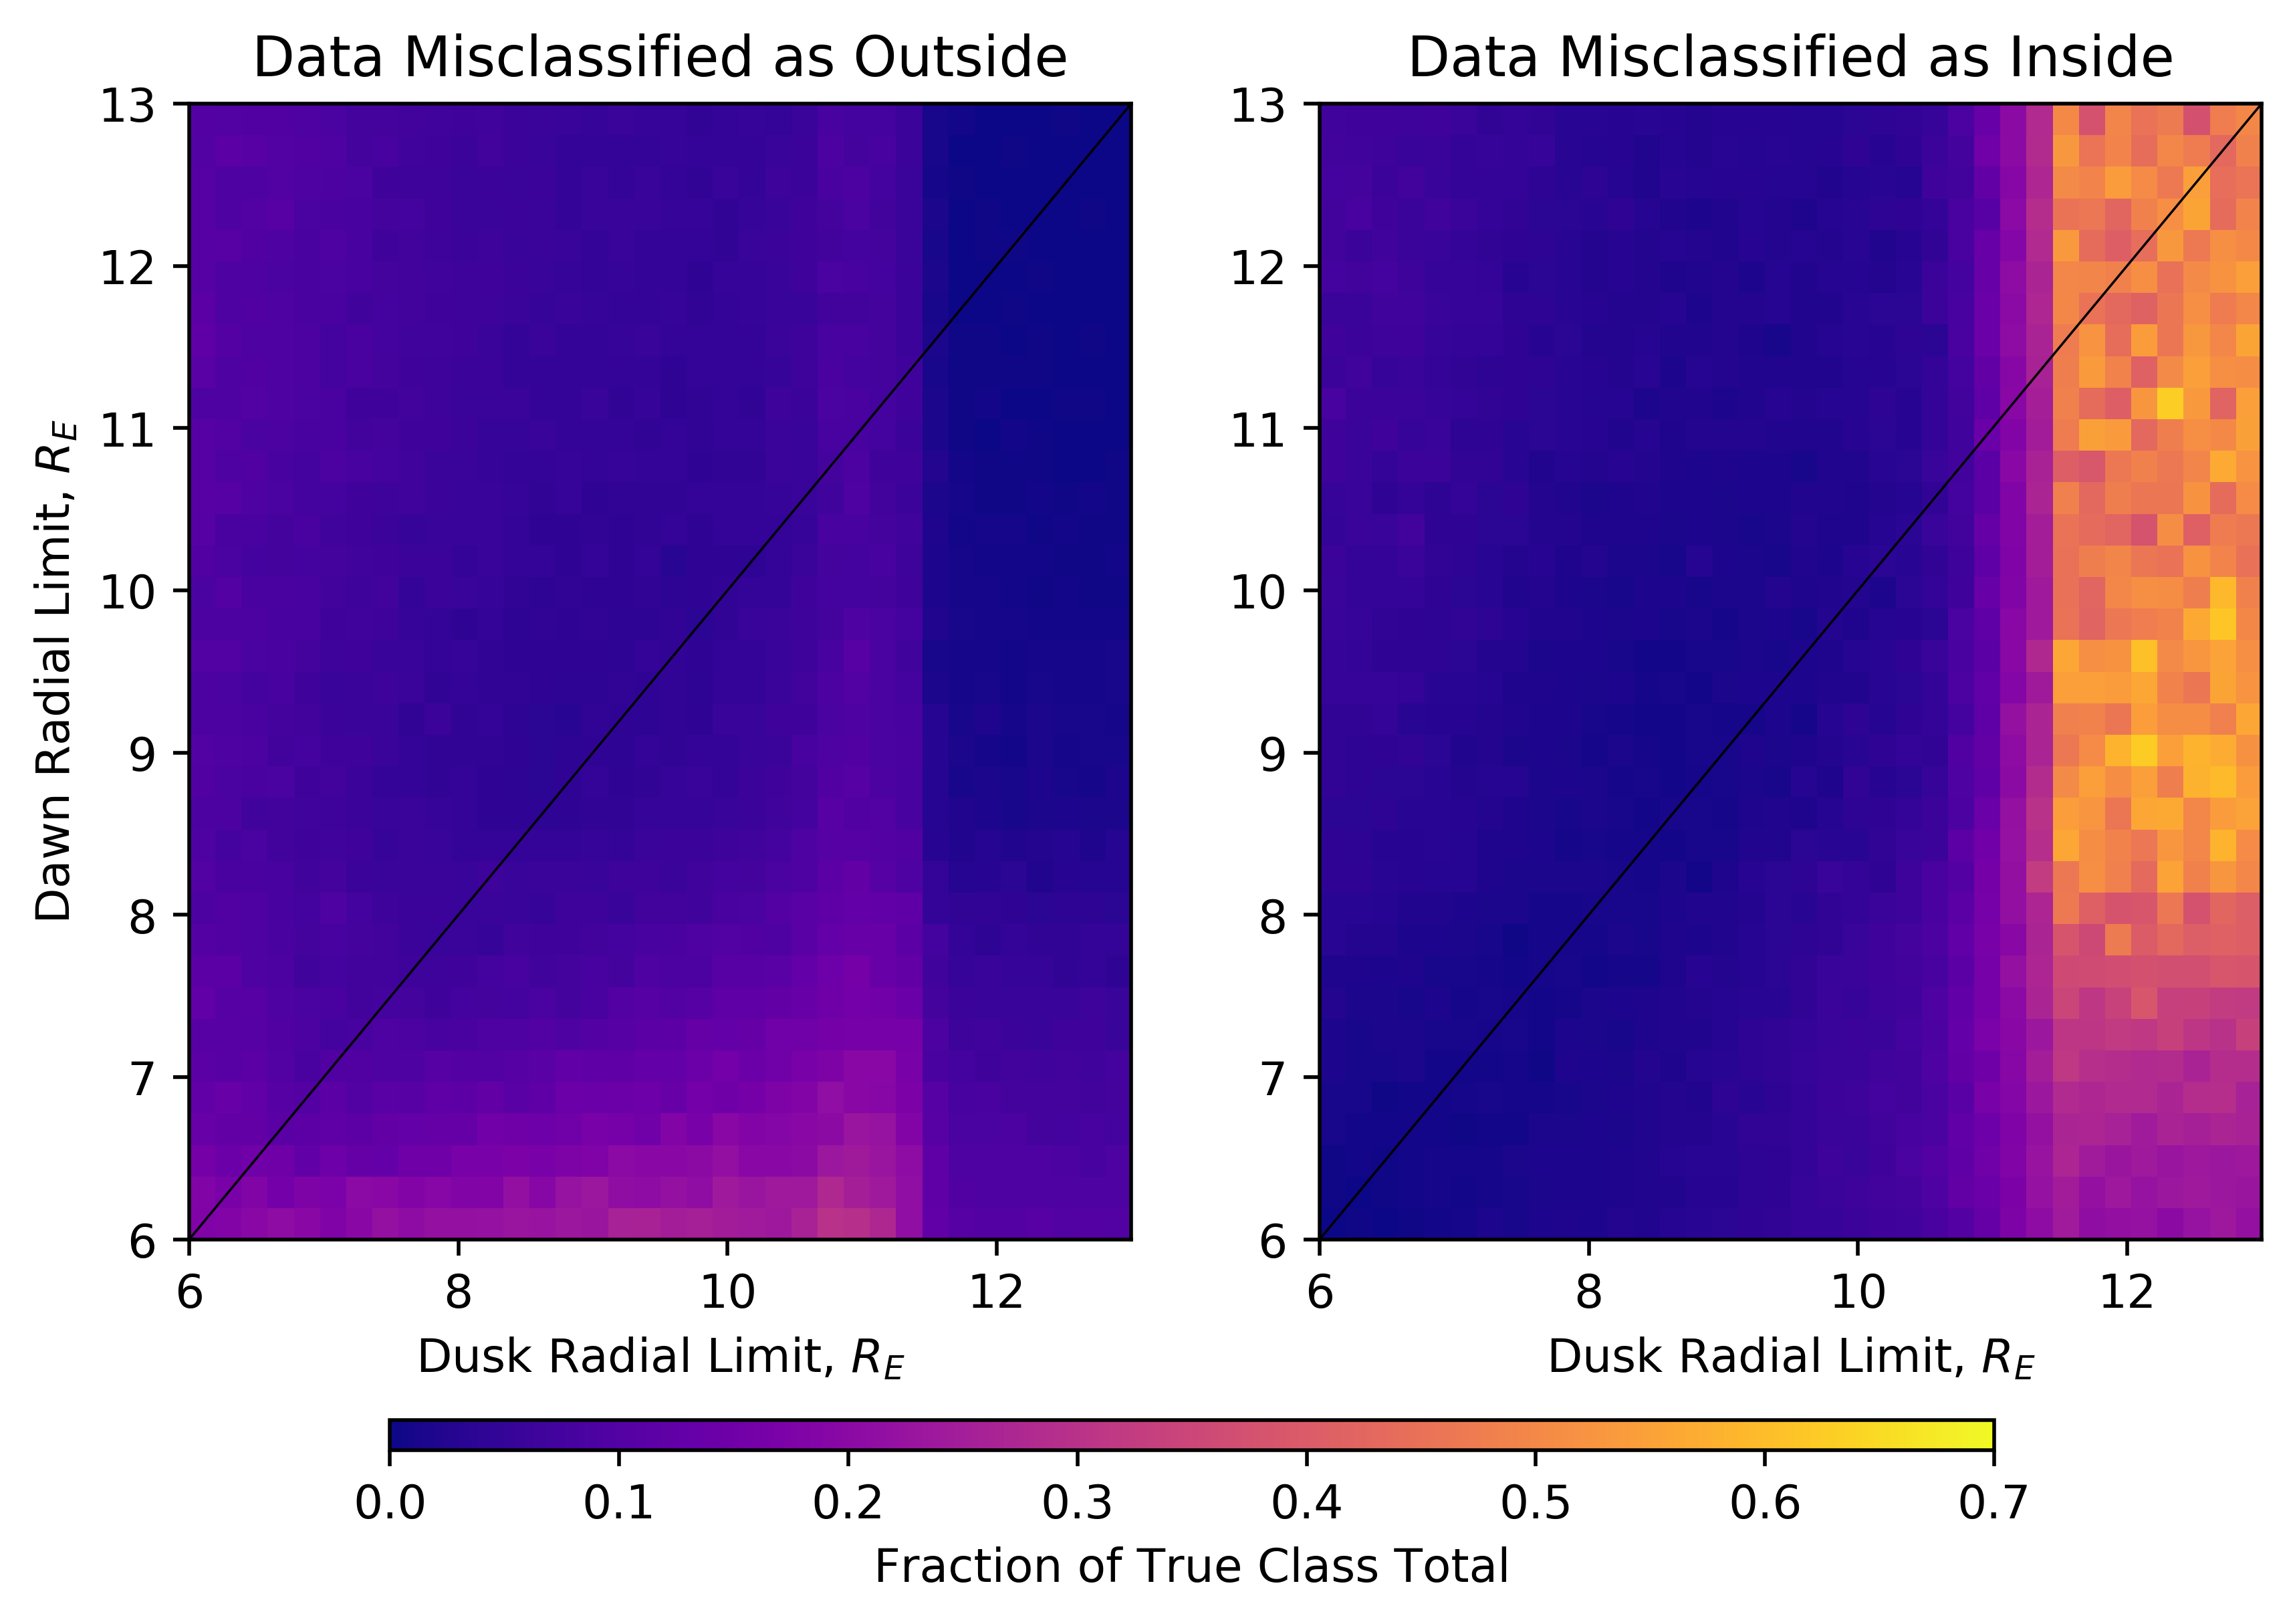

In [20]:
fig = plt.figure(figsize=(8,4.5),dpi=500)
ax1,ax2 = plt.subplot(121),plt.subplot(122)

ax1.imshow([df.iloc[i*72:(i+1)*72].True_in[1::2].values for i in range(36)],
           extent=[6,13,6,13],vmax=0.7,
           origin='lower',cmap='plasma',aspect='auto')

ax2.imshow([df.iloc[i*72:(i+1)*72].True_out[0::2].values for i in range(36)],
           extent=[6,13,6,13],vmax=0.7,
           origin='lower',cmap='plasma',aspect='auto')

ax1.plot(np.arange(6,13.2,0.2),np.arange(6,13.2,0.2),
         c='k',linewidth=0.5)
ax2.plot(np.arange(6,13.2,0.2),np.arange(6,13.2,0.2),
         c='k',linewidth=0.5)

cmap = mpl.cm.get_cmap('plasma',1000)
norm = mpl.colors.Normalize(vmin=0, vmax=0.7)
cbaxes1 = fig.add_axes([0.2, -0.015, 0.6, 0.02]) 
cb1 = mpl.colorbar.ColorbarBase(cbaxes1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Fraction of True Class Total')

ax1.set_title('Data Misclassified as Outside')
ax2.set_title('Data Misclassified as Inside')
ax1.set_ylabel('Dawn Radial Limit, $R_E$')
ax1.set_xlabel('Dusk Radial Limit, $R_E$')
ax2.set_xlabel('Dusk Radial Limit, $R_E$')

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'misclass_rate.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'misclass_rate.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'misclass_rate.png',format='png',bbox_inches='tight')

plt.show()

In [21]:
r_lim = [(i,j) for i in np.arange(6,13.2,0.2)
         for j in np.arange(6,13.2,0.2)]

total = len(dawn_f3.pos_r_mag+dusk_f3.pos_r_mag)
amnt = []
for i,j in r_lim:
    da = len(dawn_f3[(dawn_f3.pos_r_mag < i)])
    du = len(dusk_f3[(dusk_f3.pos_r_mag < j)])
    amnt.append(da+du)

In [22]:
amnt2 = np.array(amnt).reshape(36,36)

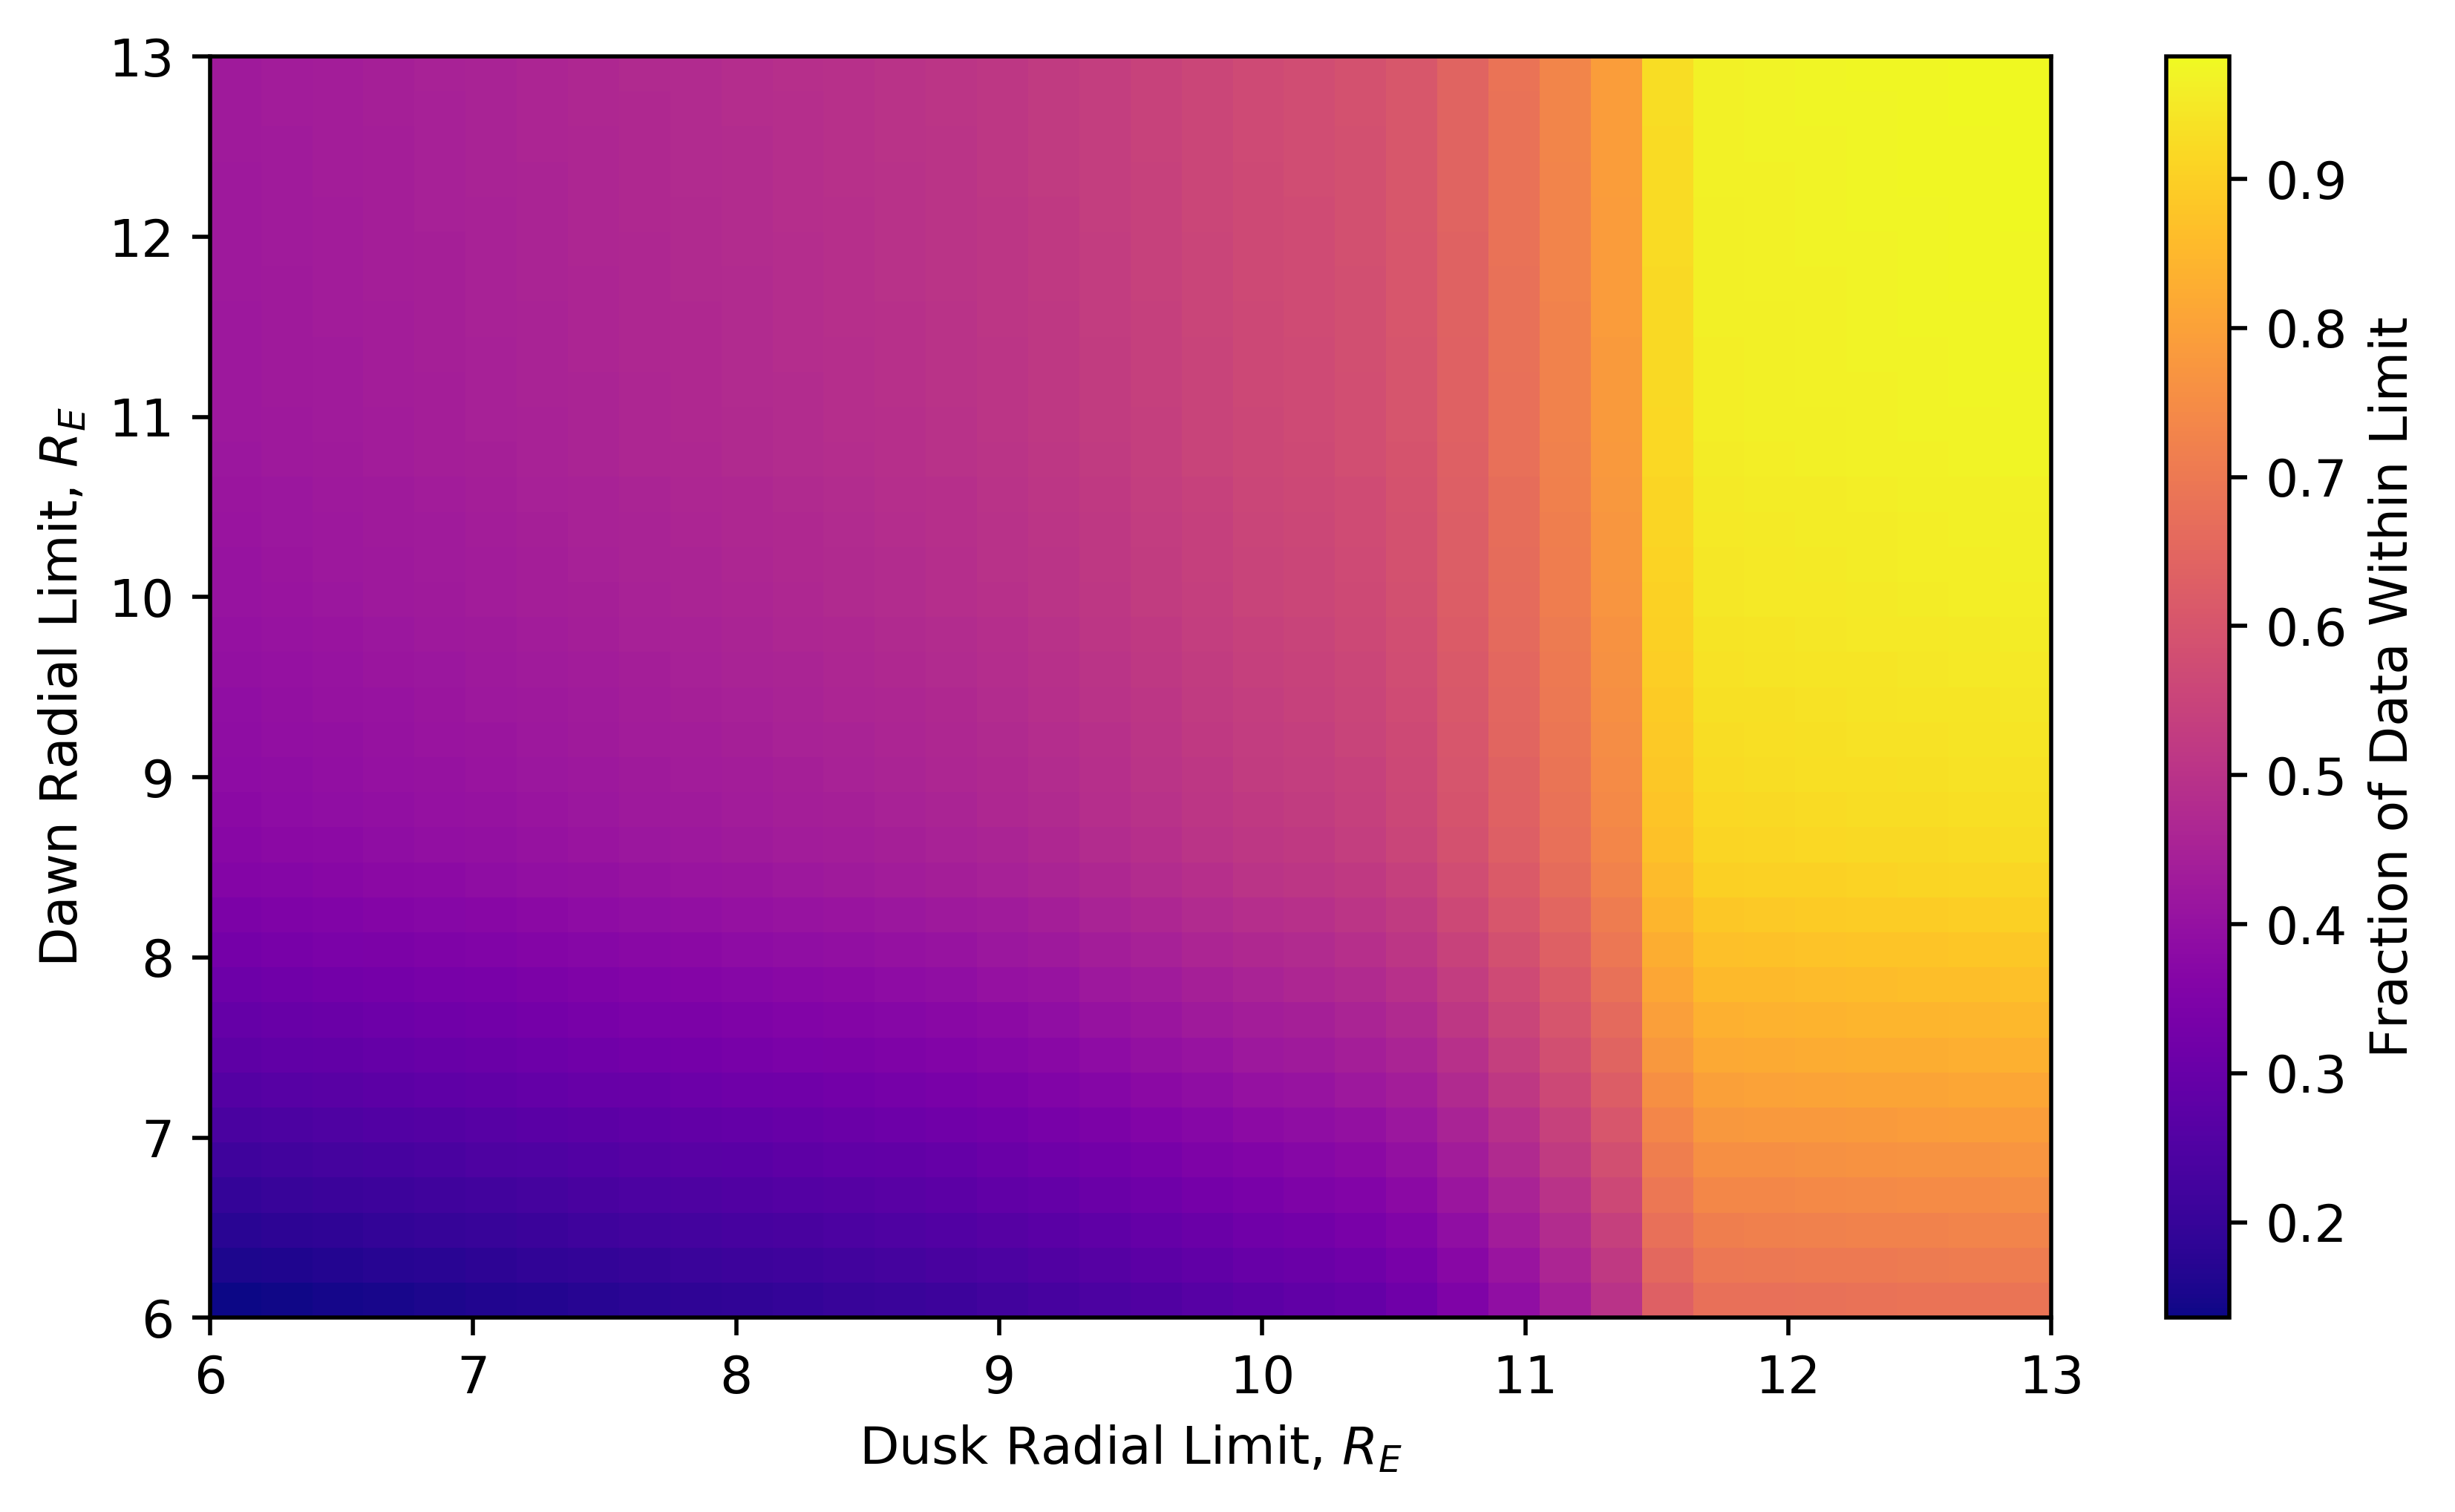

In [23]:
plt.figure(figsize=(8,4.5),dpi=500)
plt.imshow(amnt2/total,origin='lower',cmap='plasma',
           extent=[6,13,6,13],aspect='auto')

plt.ylabel('Dawn Radial Limit, $R_E$')
plt.xlabel('Dusk Radial Limit, $R_E$')
plt.colorbar().set_label('Fraction of Data Within Limit')

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'misclass_data_dist.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'misclass_rate.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'misclass_data_dist.png',format='png',bbox_inches='tight')

plt.show()

In [24]:
np.array(amnt).shape

(1296,)

In [25]:
df.head()

,Unnamed: 0,True_in,True_out
0,In_p_6.06.0,0.8182,0.0310
1,Out_p_6.06.0,0.1818,0.9690
2,In_p_6.06.2,0.8119,0.0326
3,Out_p_6.06.2,0.1881,0.9674
4,In_p_6.06.4,0.8024,0.0288


In [26]:
inlen = np.array([[i,i] for i in amnt]).reshape(2592)
outlen = total-inlen

In [27]:
numdf = df.copy()
numdf['True_in'] = df.True_in.values*inlen
numdf['True_out'] = df.True_out.values*outlen
numdf.head()

,Unnamed: 0,True_in,True_out
0,In_p_6.06.0,6352.5048,1528.7650
1,Out_p_6.06.0,1411.4952,47786.2350
2,In_p_6.06.2,6567.4591,1597.0740
3,Out_p_6.06.2,1521.5409,47392.9260
4,In_p_6.06.4,6720.9024,1402.6464


In [28]:
tp = numdf.True_in.values[::2]
tn = numdf.True_out.values[1::2]
fp = numdf.True_out.values[::2]
fn = numdf.True_in.values[1::2]

In [29]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
sensitivity = recall
specificity = tn/(tn+fp)

In [30]:
accuracy = (tp+tn)/total
gmean = np.sqrt(sensitivity*specificity)
fmeasure = (2*precision*recall)/(precision+recall)

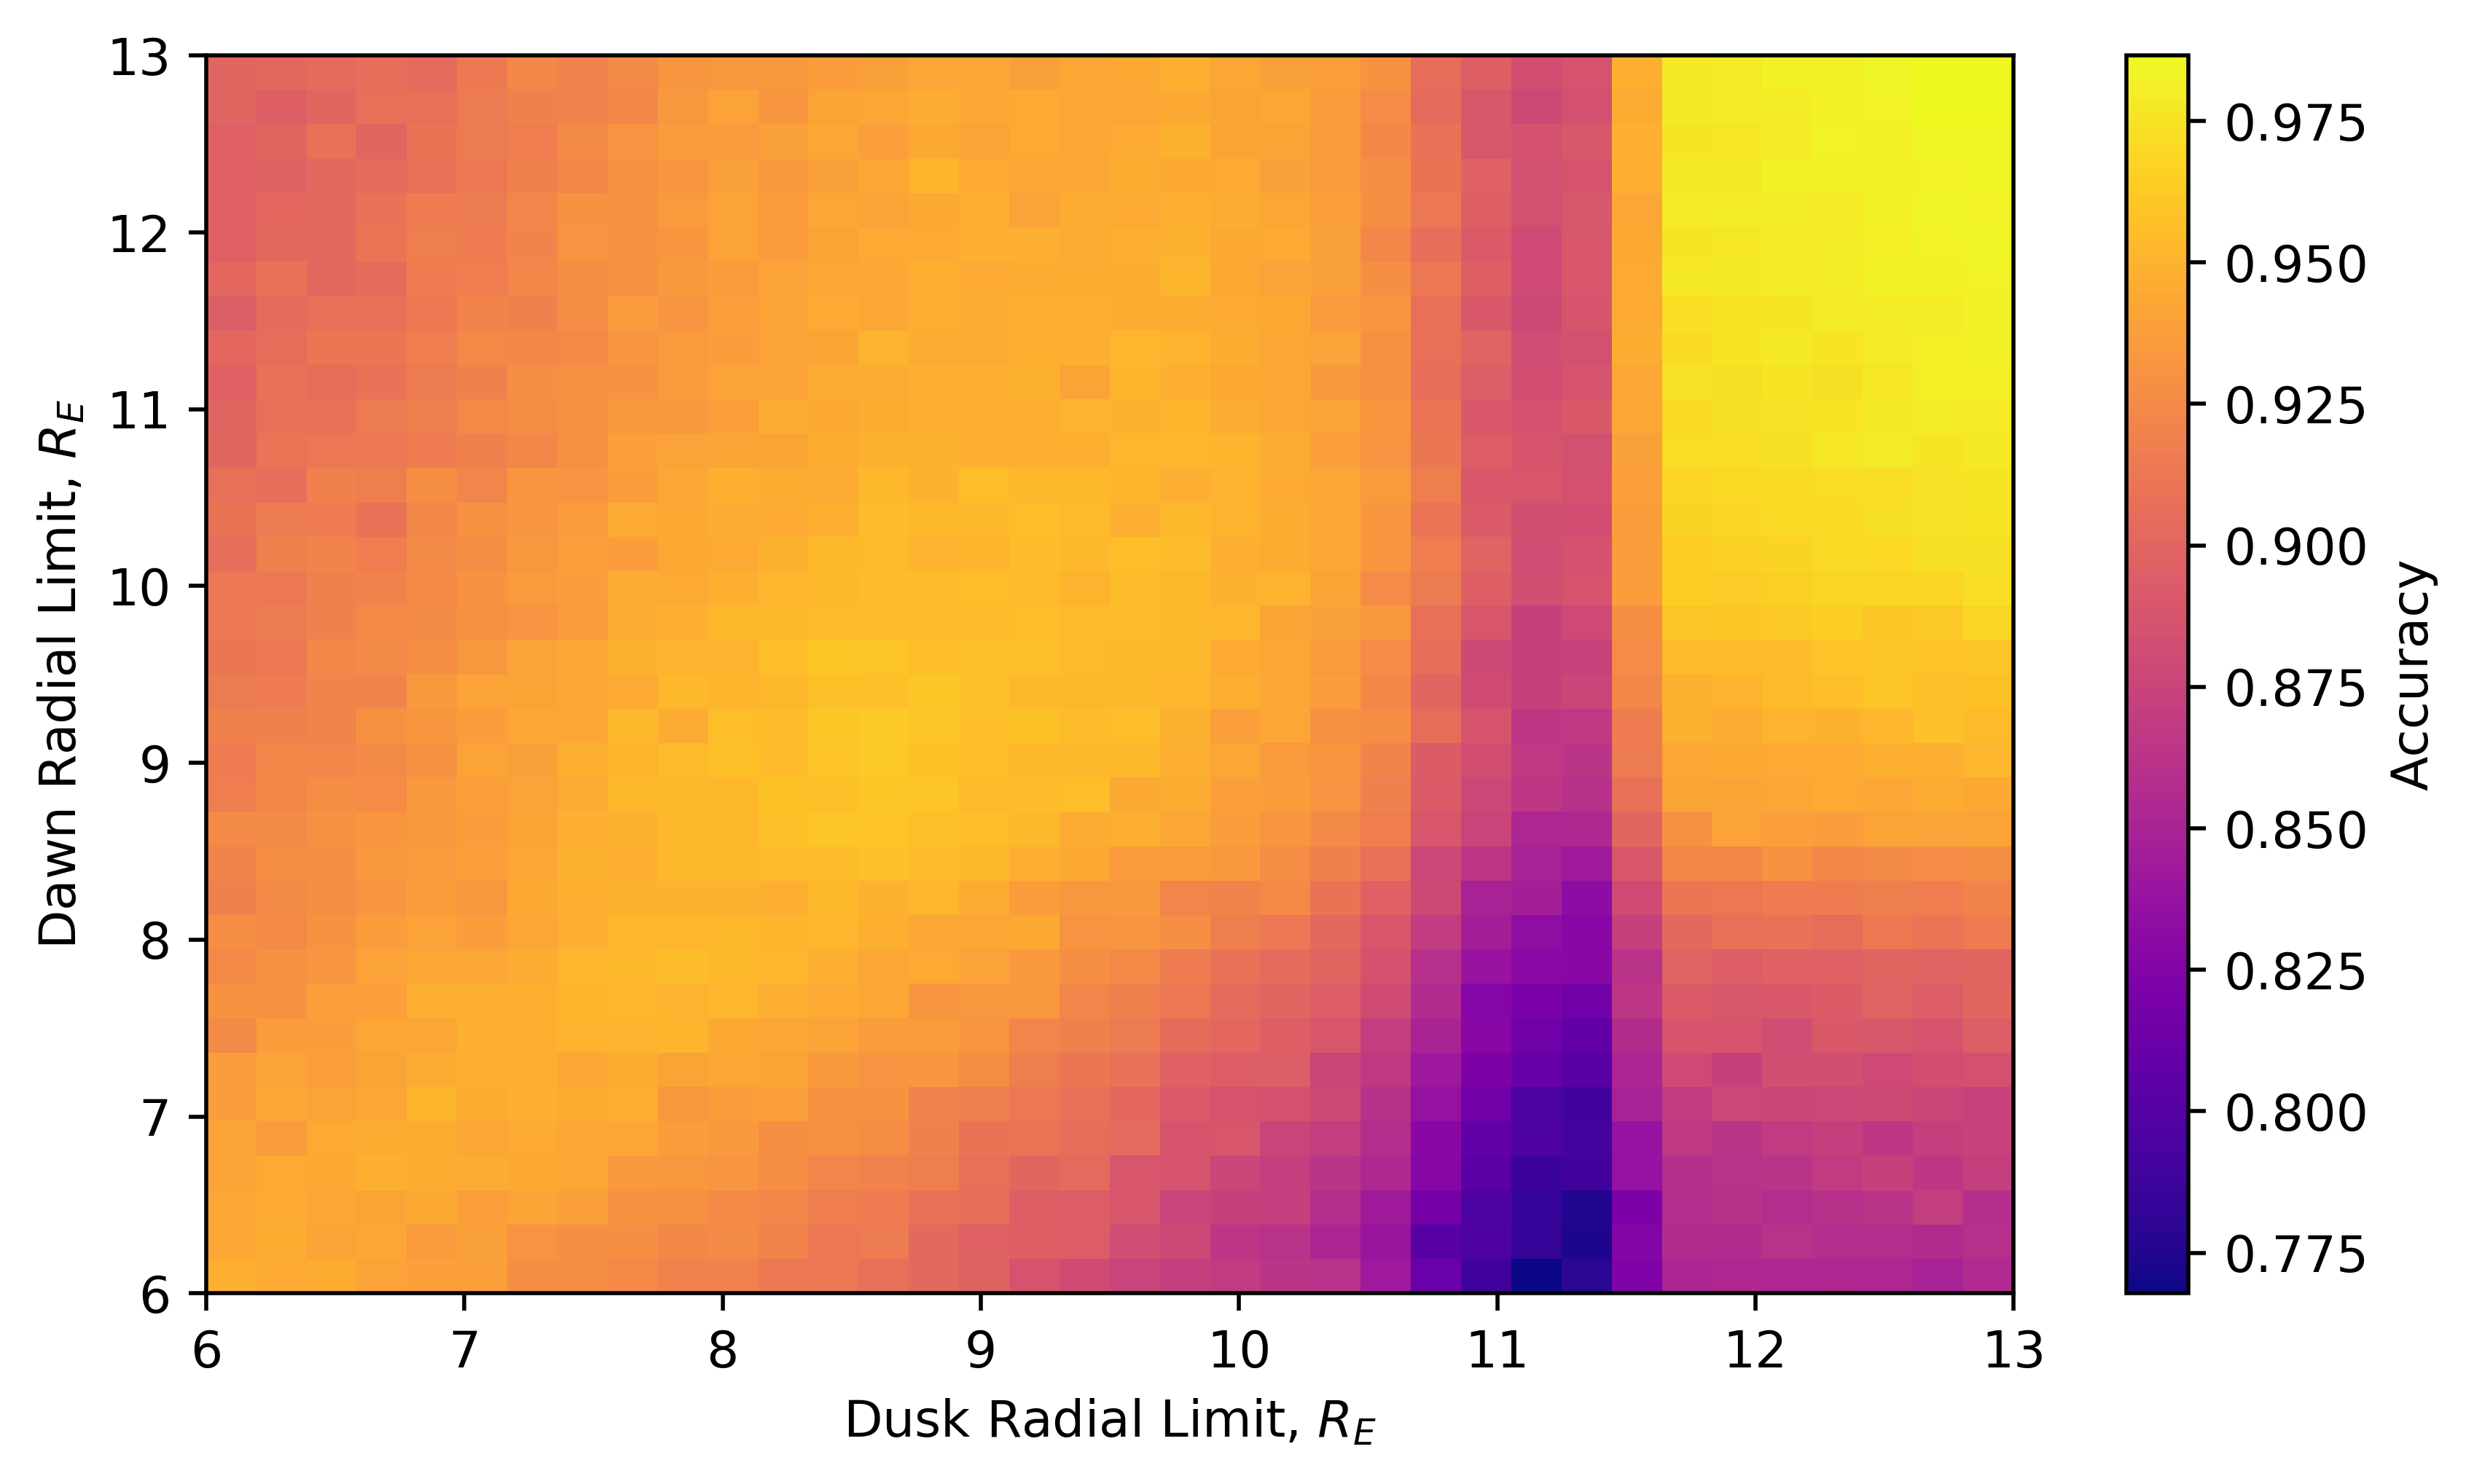

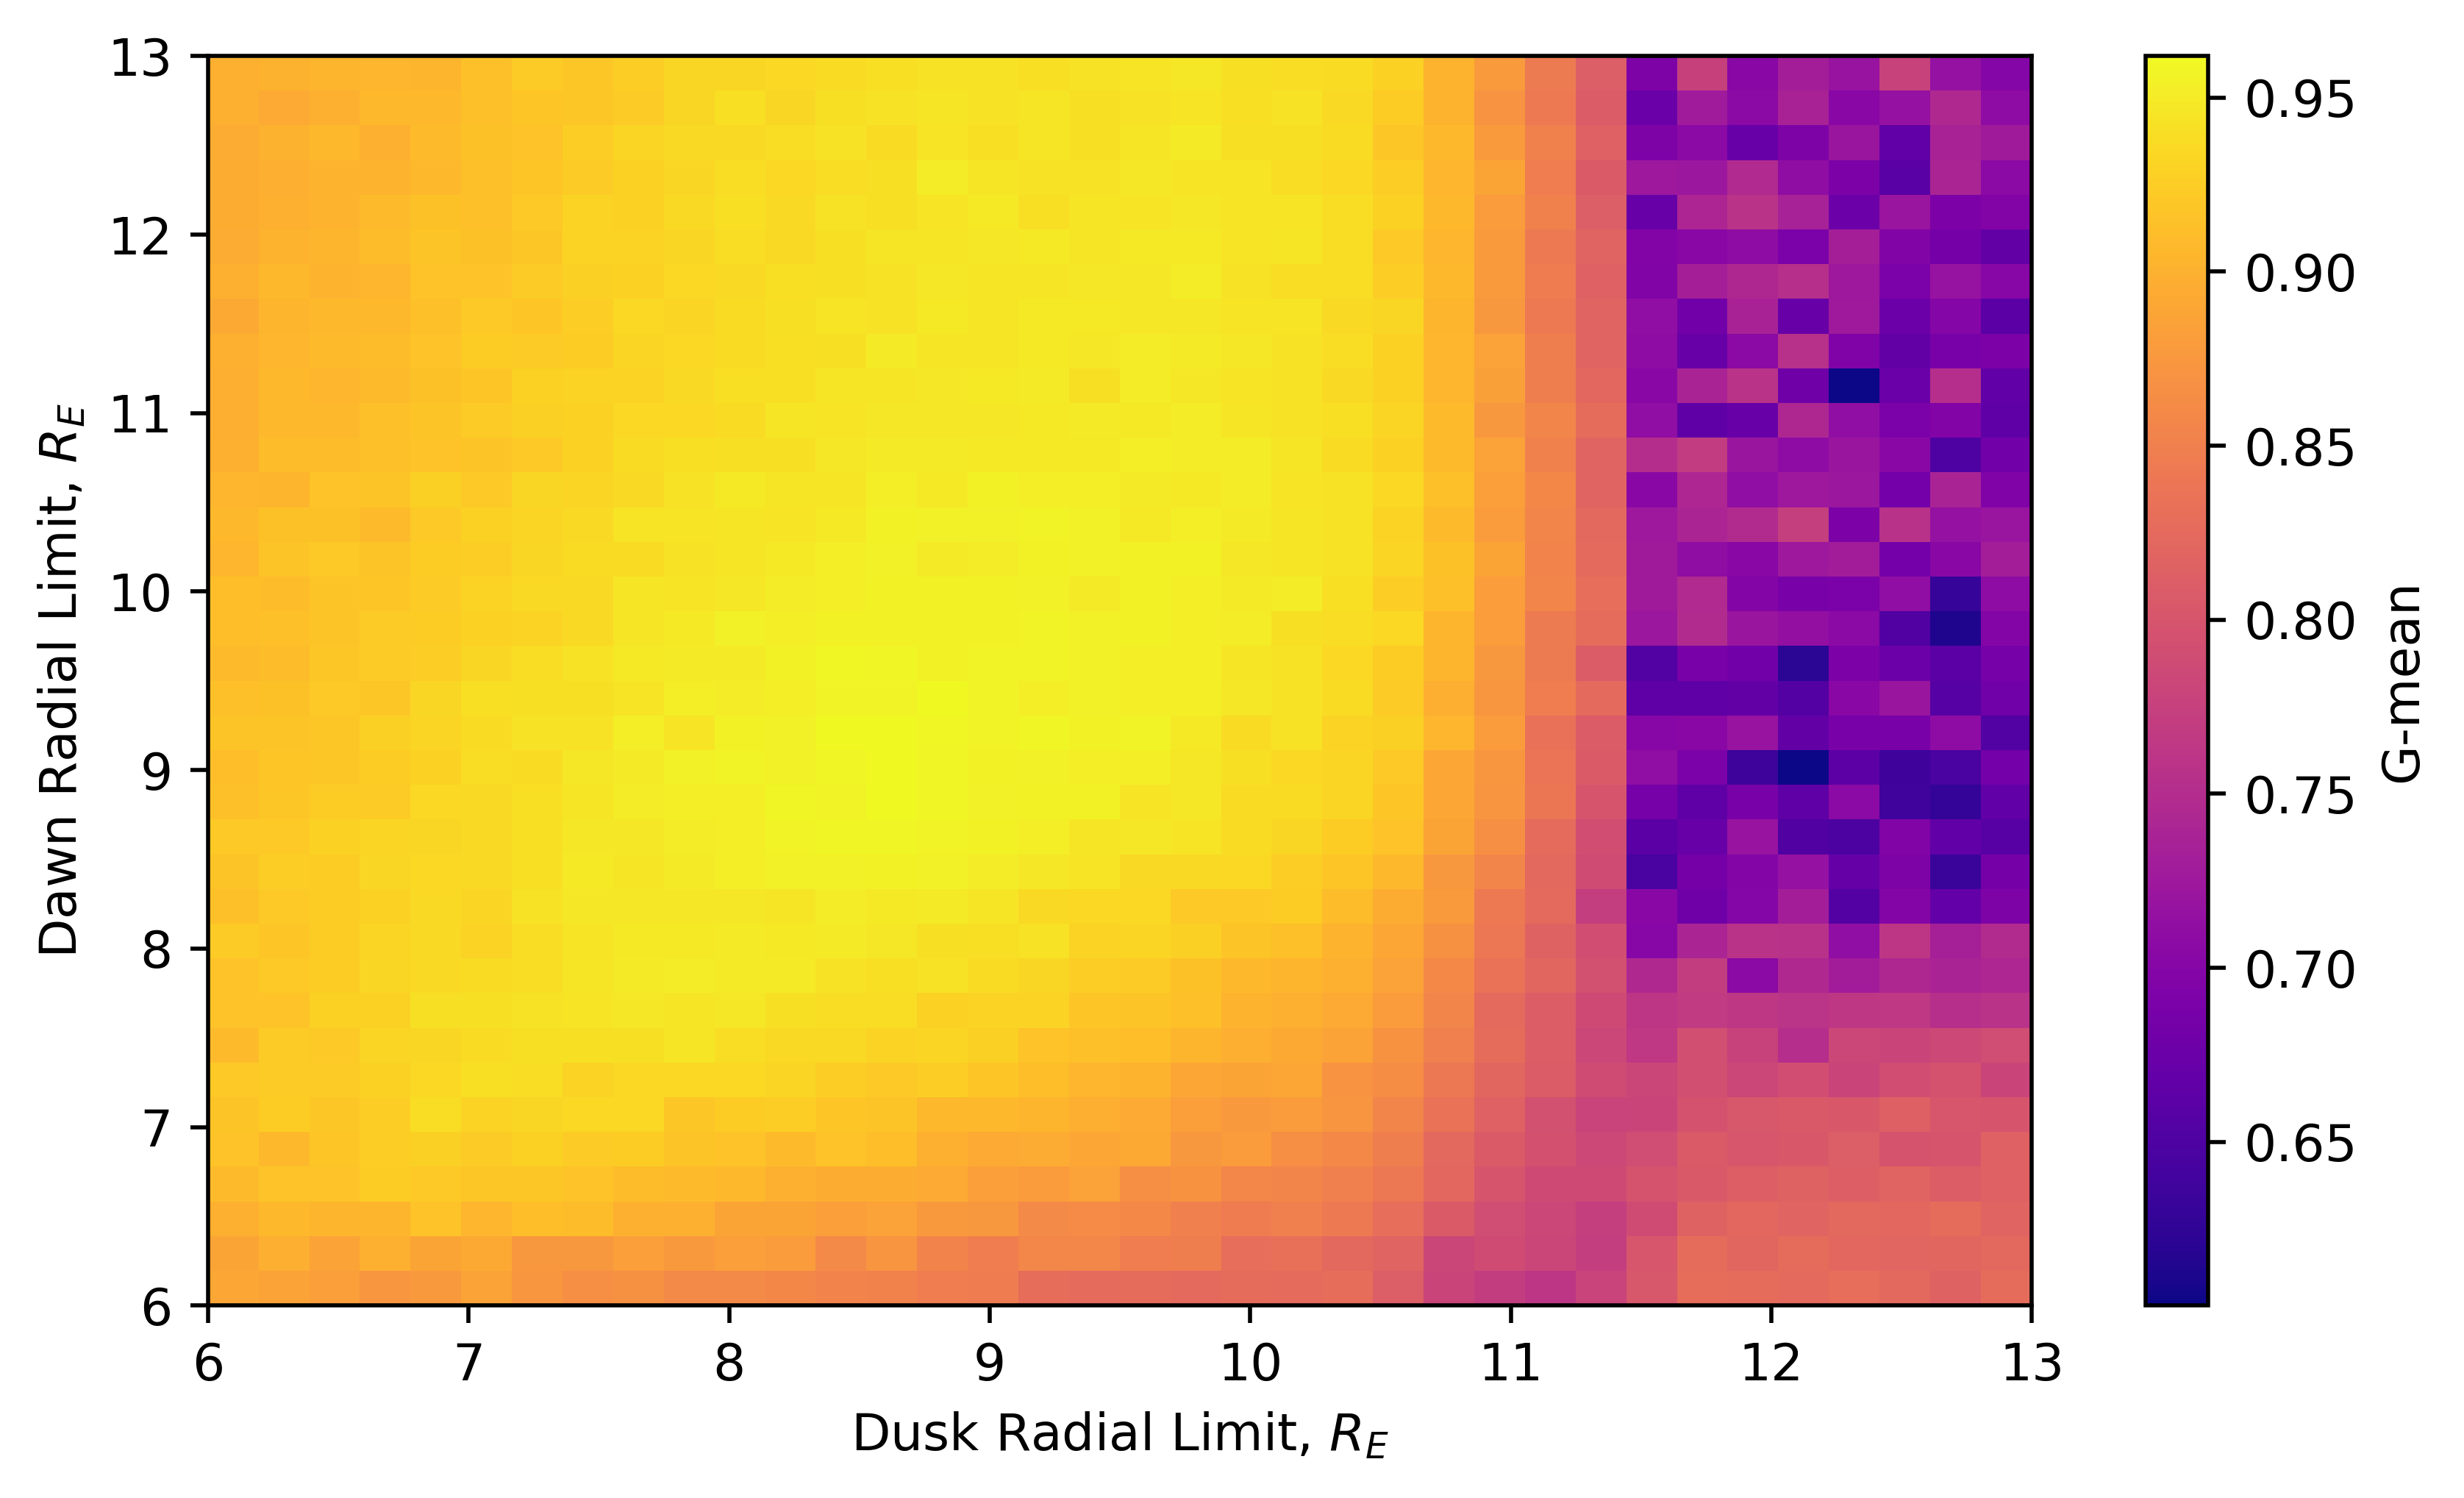

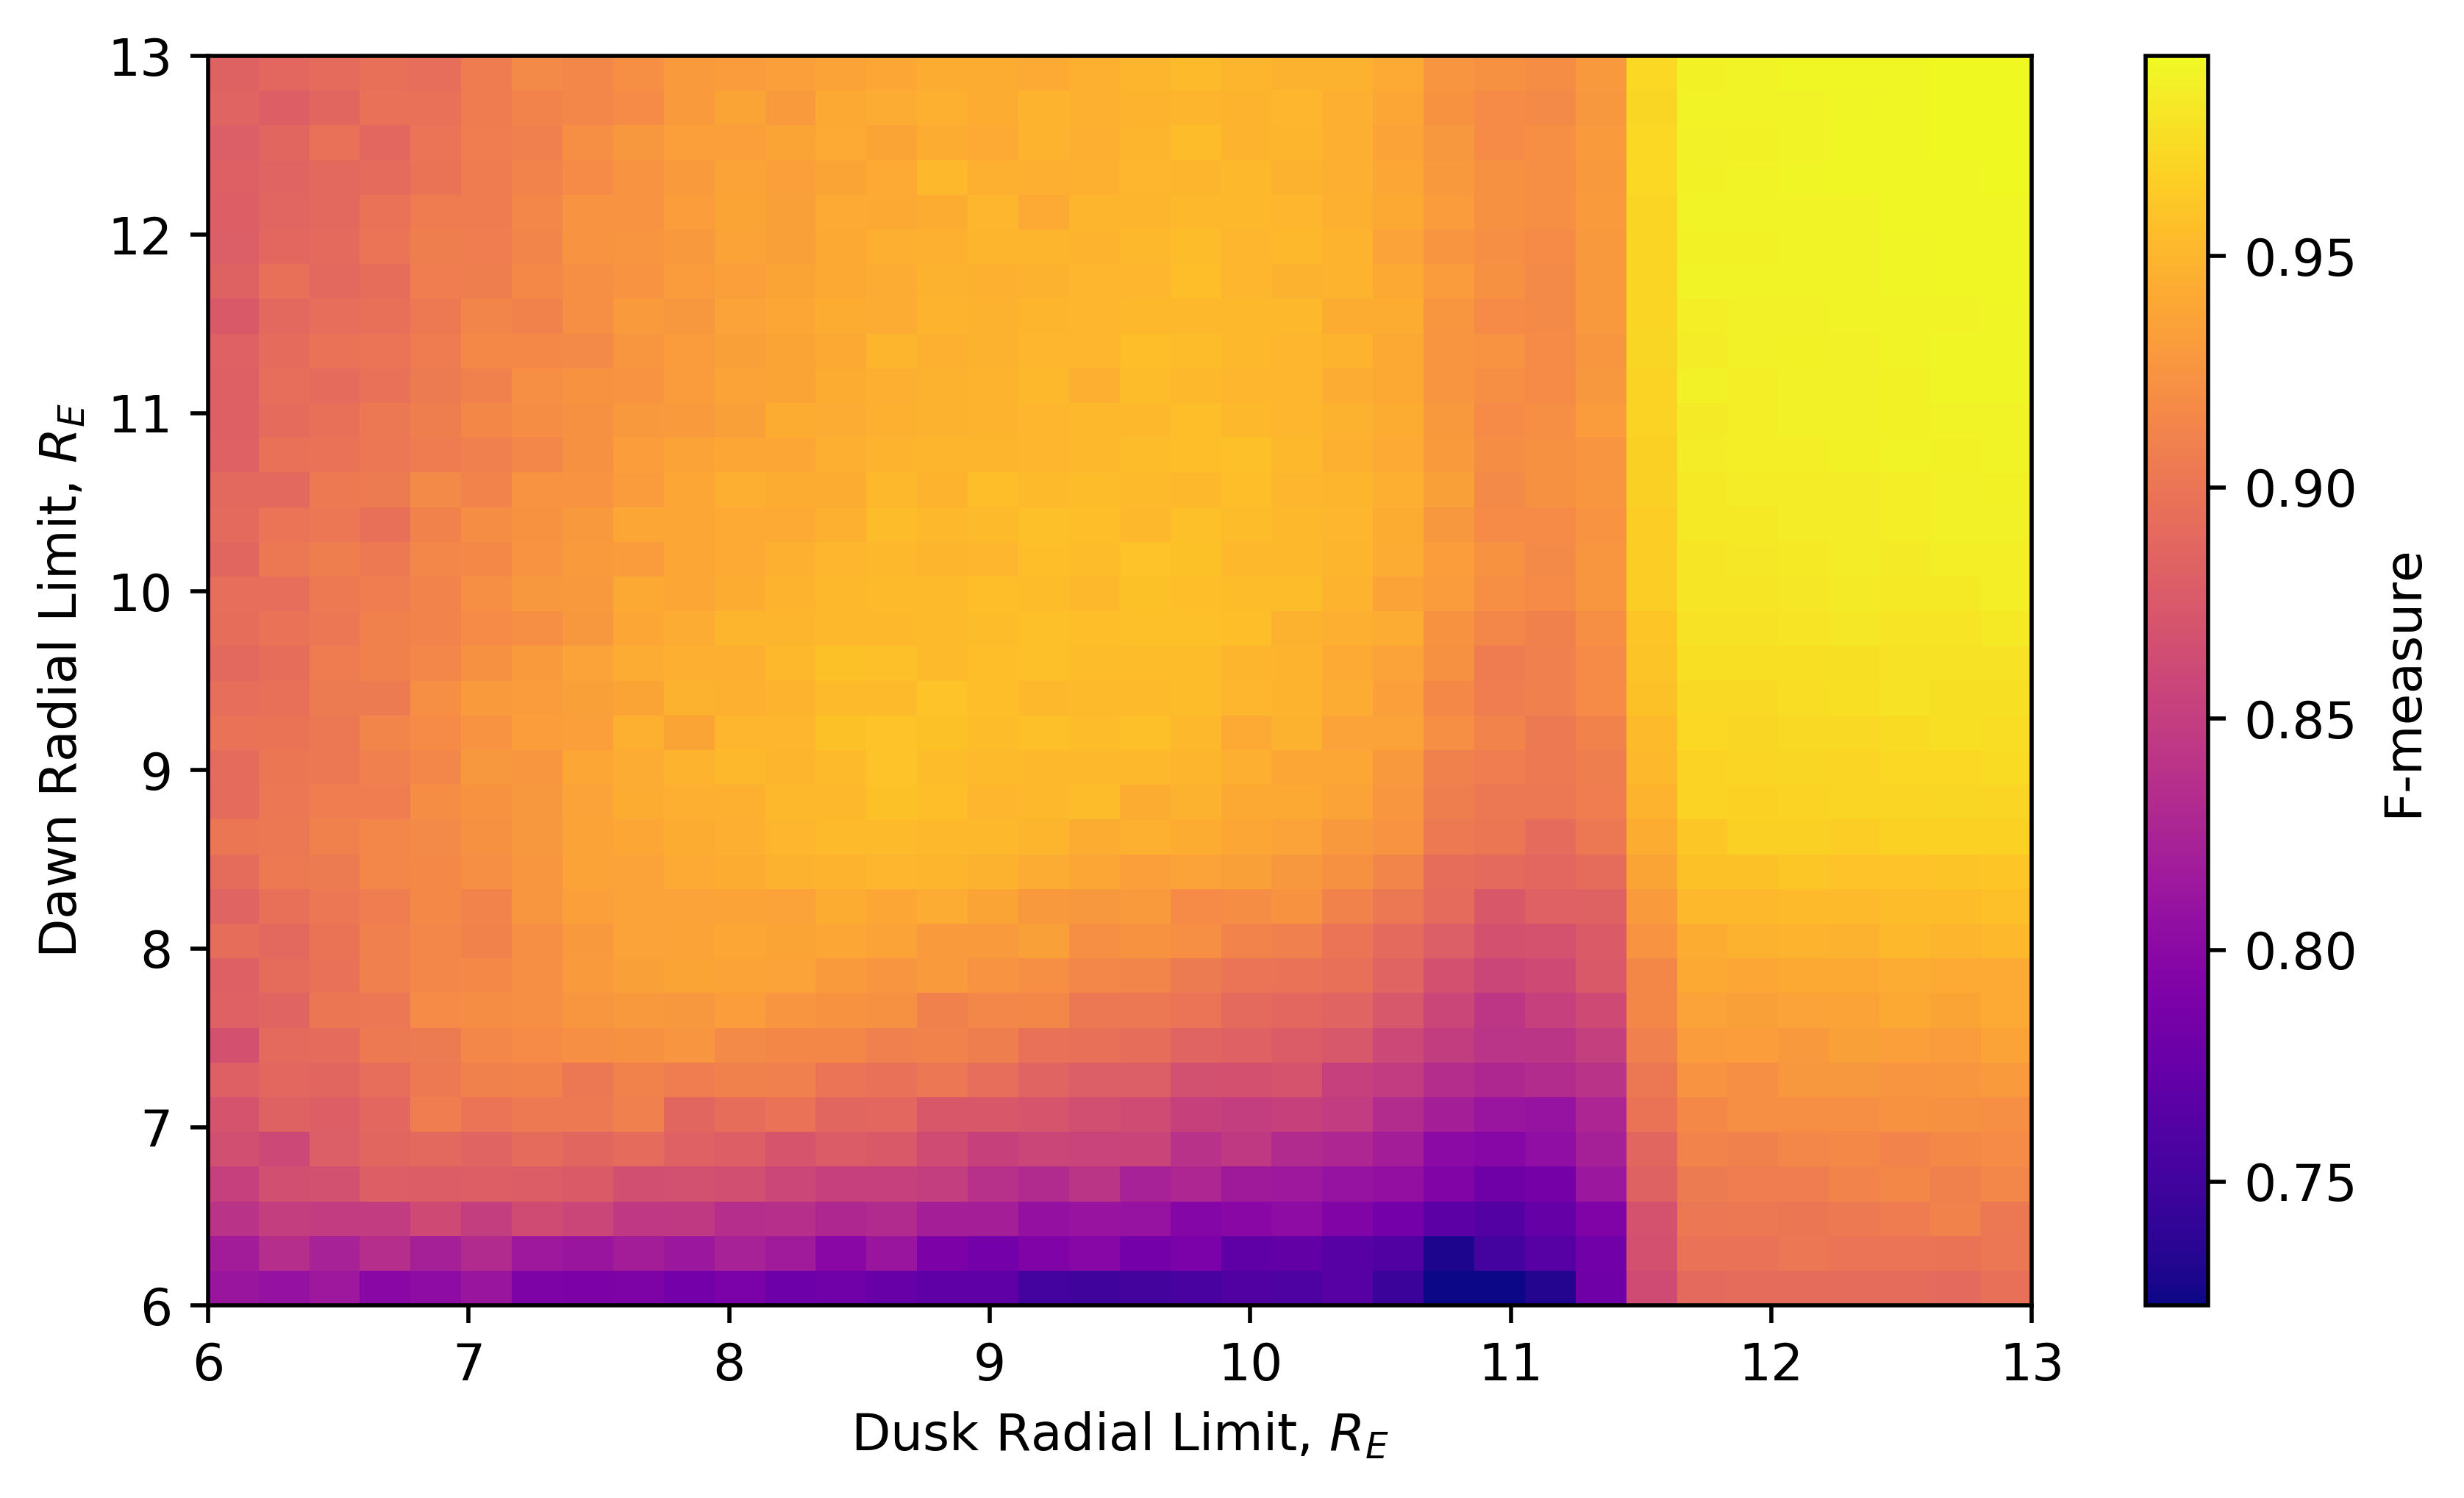

In [31]:
for i,j in zip([accuracy,gmean,fmeasure],['Accuracy','G-mean','F-measure']):
    score_metric = i.reshape(36,36)
    plt.figure(figsize=(8,4.5),dpi=500)
    plt.imshow(score_metric,origin='lower',cmap='plasma',
               extent=[6,13,6,13],aspect='auto')

    plt.ylabel('Dawn Radial Limit, $R_E$')
    plt.xlabel('Dusk Radial Limit, $R_E$')
    plt.colorbar().set_label(j)
    plt.show()

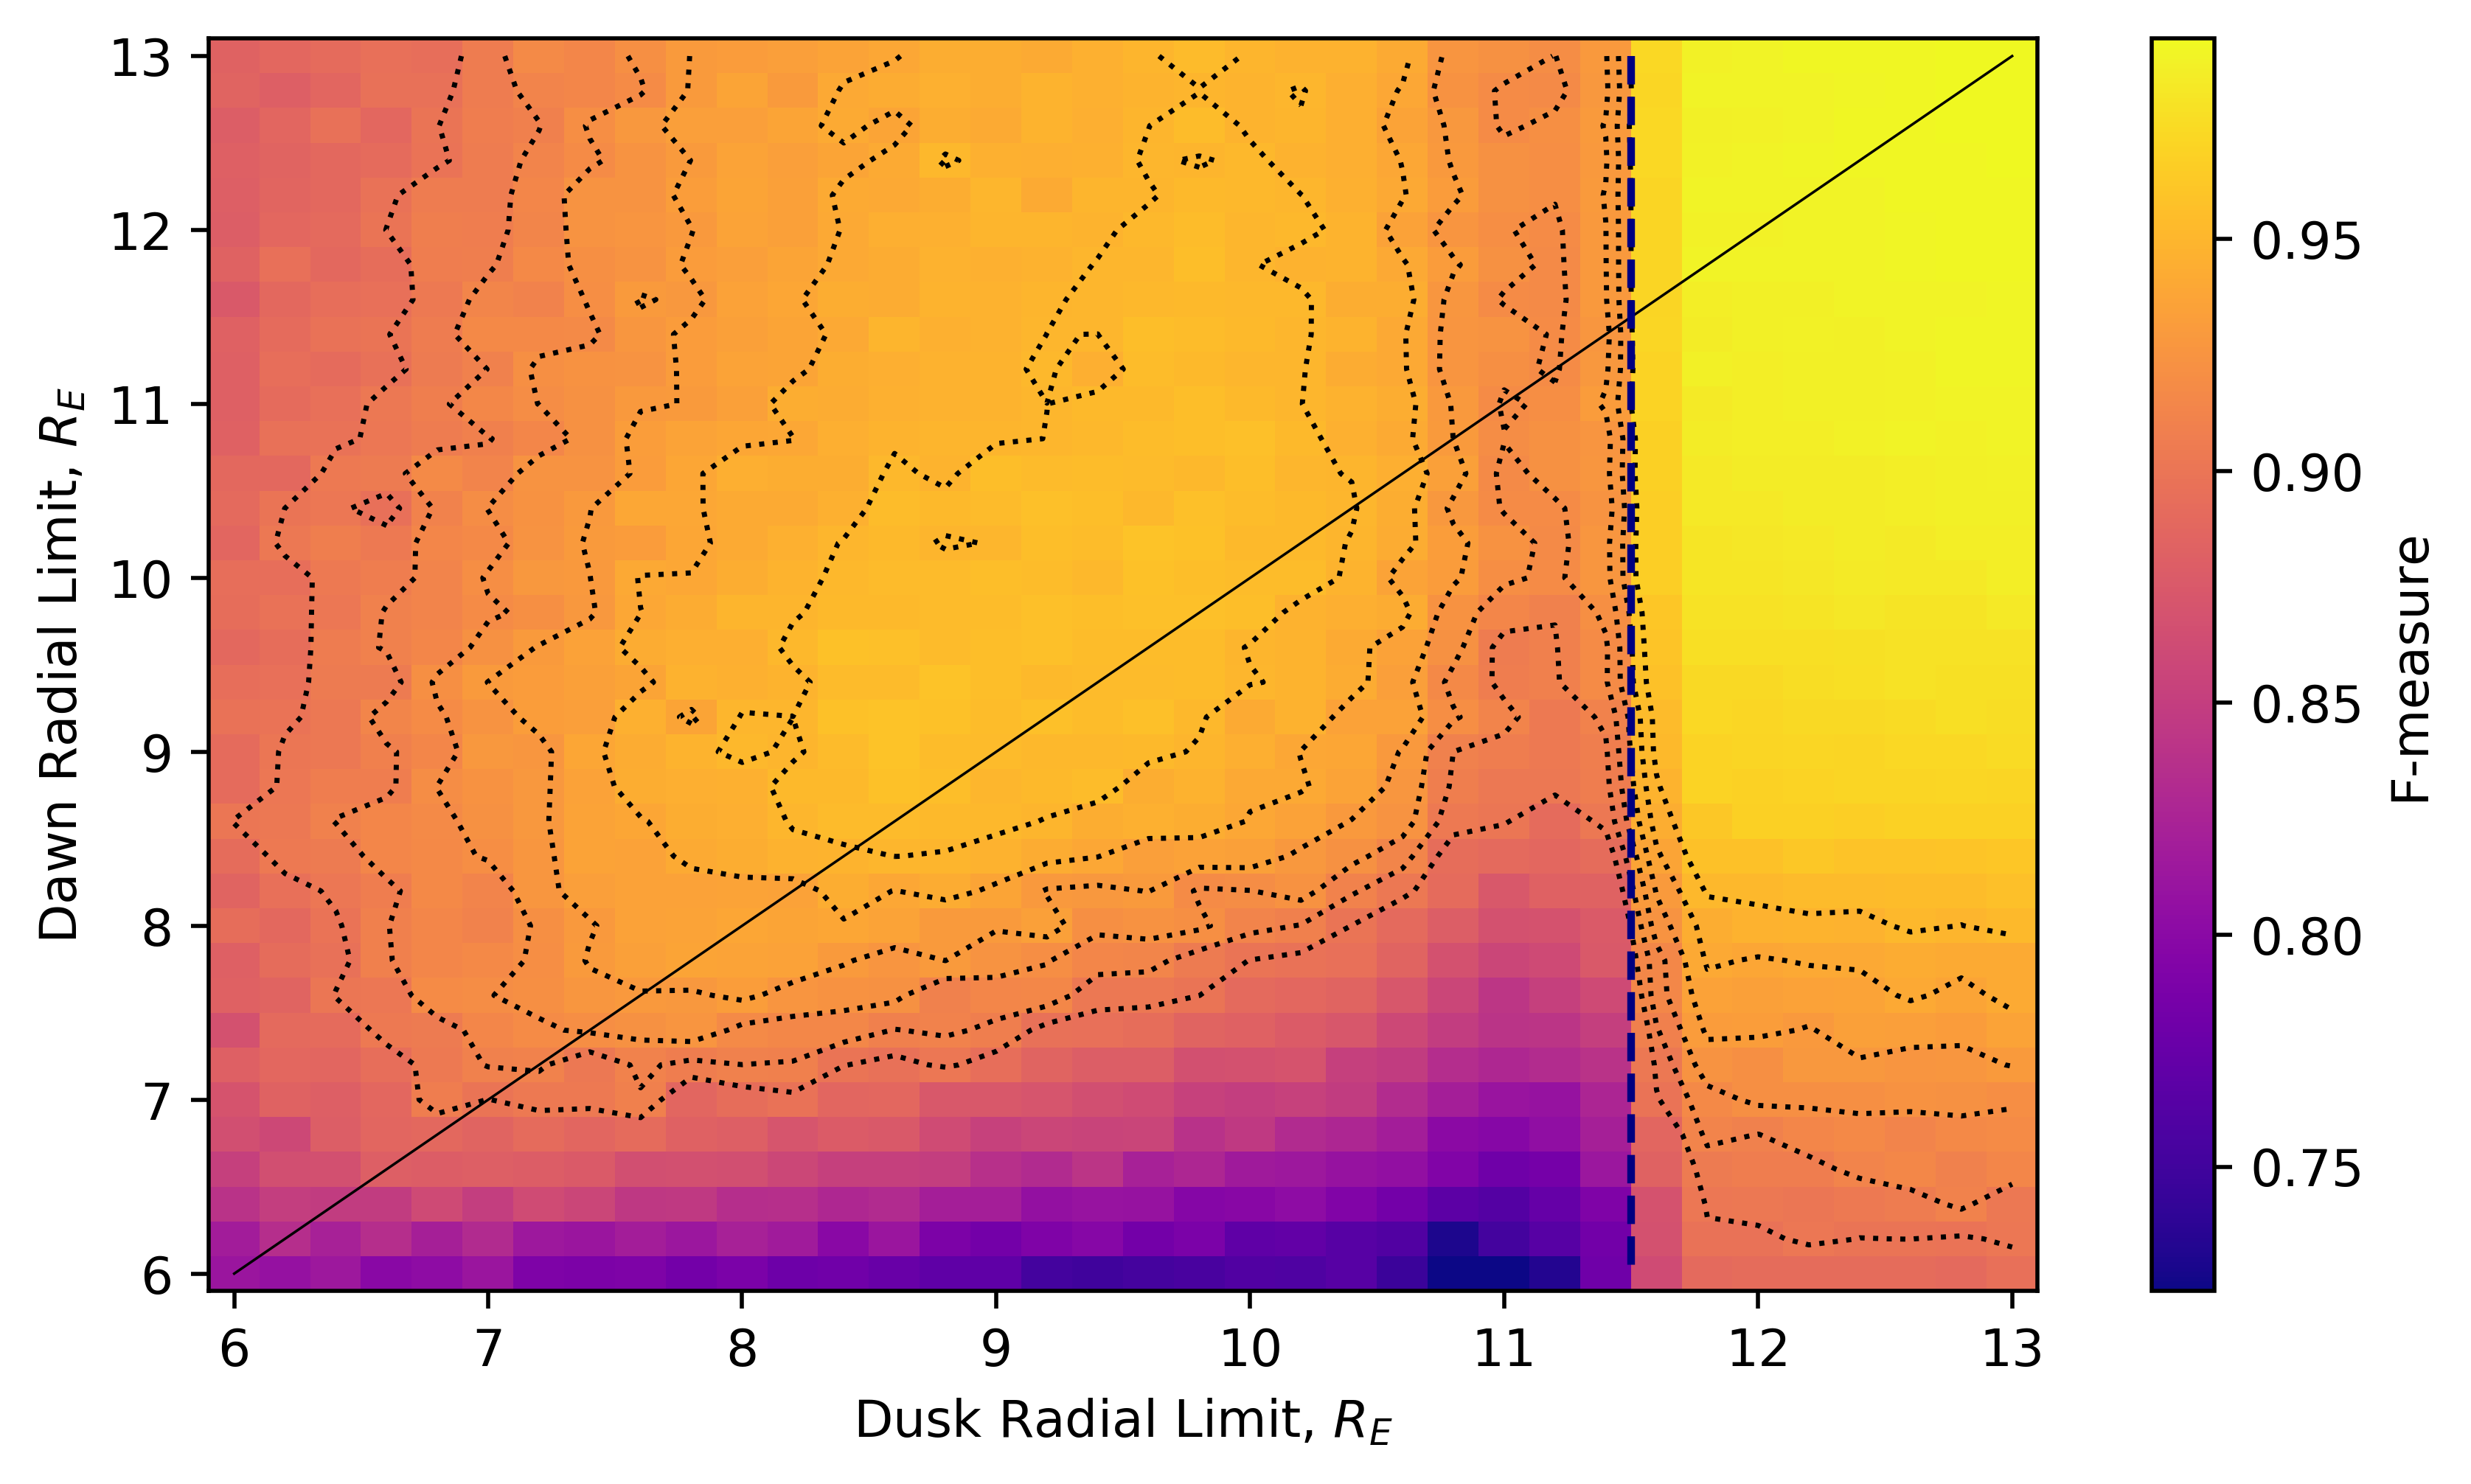

In [114]:
score_metric = fmeasure.reshape(36,36)

plt.figure(figsize=(8,4.5),dpi=500)

plt.imshow(score_metric,origin='lower',cmap='plasma',
           extent=[5.9,13.1,5.9,13.1],aspect='auto')
plt.colorbar().set_label('F-measure')

XC = np.arange(6,13.2,0.2)
YC = np.arange(6,13.2,0.2)
ZC = score_metric
plt.contour(XC,YC,ZC,levels=np.arange(0.9,0.96,0.01),
            colors='k',linewidths=1,linestyles='dotted')

plt.plot(XC,YC,c='k',linewidth=0.5)
plt.plot([11.5,11.5],[13,6],c='navy',linestyle='--')

plt.ylabel('Dawn Radial Limit, $R_E$')
plt.xlabel('Dusk Radial Limit, $R_E$')

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'spvsd_fmeasure.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'misclass_rate.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'spvsd_fmeasure.png',format='png',bbox_inches='tight')

plt.show()